# Appliances with duty cycles


Some appliances may operate based on fixed duty cycle. For instance, you may think of a
dishwasher that follows a pre-determined program. This can be modelled by means of the 
`fixed_cycle` parameter, which allows to define a duty cycle consisting of up to two temporal
operation segments with distinct power consumption levels. 

Furthermore, we acknowledge that some of the appliances that can operate based on duty cucles
may still follow multiple, different duty cycles throughout a day or across seasons. An example
of an appliance characterised by variable duty cycles is a fridge. Fridges tend to follow 
different duty cycles throughout the day, depending on the ambient temperature (which also varies
across seasons) and/or frequency of user interaction (e.g., how often the door gets opened).
Accordingly, RAMP allows modelling up to 3 different duty cycles per appliance, giving room for
modulating the appliance's behaviour depending on any given factor of interest.

In this example, we model a fridge with 3 different duty cycles, which are representative of its
operation during a 'hot' season. The time windows are defined for 3 different cycles throughout
the day, corresponding to a different temperature and frequency of user interaction. For instance,
between 08:00 and 20:00, we assume that the fridge operates more intensely due to the combined effects
of temperature and frequent use. In the early morning, it operates at an intermediate intensity, 
and during the night, it operates based on its standard cycle.


| season type |               Standard cycle              |  Intermediate cycle |   Intensive cycle   |
|-------------|:-----------------------------------------:|:-------------------:|:-------------------:|
| Hot         | 00:00:00 - 04:59:00 & 20:01:00 - 23:59:00 | 05:00:00 - 07:59:00 | 08:00:00 - 20:00:00 |

### Creating the user and appliance

In [1]:
# importing functions
from ramp import User, UseCase, get_day_type
import pandas as pd

In [2]:
# creating user
household = User()

In [ ]:
# creating the appliance
fridge = household.add_appliance(
    name="Fridge",
    number=1,
    power=200,
    num_windows=1,
    func_time=1400,
    time_fraction_random_variability=0,
    func_cycle=30,
    fixed="yes",
    fixed_cycle=3,  # number of cycles
)

In [4]:
# setting the functioning windows
fridge.windows([0, 1440])  # always on during the whole day, for all days of the year

### Characterising the specific cycles

As anticipated above, each cycle is characterised by two operation segments at different power levels. They can be defined as per the code below. In addition, it is possible to apply a random variability (`r_c1`, `r_c2`, `r_c3`, one for each specific cycle) to the exact duration of the two segments (see the API documentation). In this example, we do not apply such variability.

In [5]:
# assiging the specific cycles
# first cycle: standard cycle
fridge.specific_cycle_1(
    p_11=200,  # power level for the first operation segment
    t_11=10,  # duration of the first operation segment
    p_12=5,  # power level for the second operation segment
    t_12=20,  # duration of the second operation segment
    r_c1=0,  # random variability assigned to the duration of each segment
)

# second cycle: intermediate cycle
fridge.specific_cycle_2(p_21=200, t_21=15, p_22=5, t_22=15, r_c2=0)

# third cycle: intensive cycle
fridge.specific_cycle_3(p_31=200, t_31=20, p_32=5, t_32=10, r_c3=0)

After defining the cycle power and duration parameters, the time windows within a day at which the cycles occur should be specified by means of the 'cycle window' (`cw`). In fact, up to two time windows within a day can be specified for each of the 3 cycles. For instance, according to the table discussed earlier, for the standard `specific_cycle_1` we may define an occurrence in the early morning (`cw11` in the code below) as well as one in the late evening (`cw12`).The windows defined across all cycles should not overlap.

In [6]:
# defining cycle behaviour
fridge.cycle_behaviour(
    cw11=[0, 299], cw12=[1201, 1440], cw21=[300, 479], cw31=[480, 1200]
)

### Building the profiles

In [7]:
use_case = UseCase(users=[household])
use_case.peak_time_range = use_case.calc_peak_time_range()

In [8]:
# days to build the profiles
days = [
    "2020-12-16",  # a day in the 'Hot' season, assuming a location in the Southern hemisphere
]

profiles = pd.DataFrame(index=range(0, 1440), columns=days)

for day_idx, day in enumerate(days):
    profile = household.generate_single_load_profile(
        prof_i=day_idx,  # the day to generate the profile
        day_type=get_day_type(day),
    )

    profiles[day] = profile

print(profiles)

The app Fridge has duty cycle option on, however the switch on event fell outside the provided duty cycle windows
The app Fridge has duty cycle option on, however the switch on event fell outside the provided duty cycle windows
      2020-05-16  2020-08-16  2020-12-16
0          0.001       0.001       0.001
1          0.001       0.001       0.001
2          0.001       0.001       0.001
3          0.001       0.001       0.001
4          0.001       0.001       0.001
...          ...         ...         ...
1435       0.001     200.000       0.001
1436       0.001     200.000       0.001
1437       0.001       0.001       0.001
1438       0.001       0.001       0.001
1439       0.001       0.001       0.001

[1440 rows x 3 columns]


<AxesSubplot:>

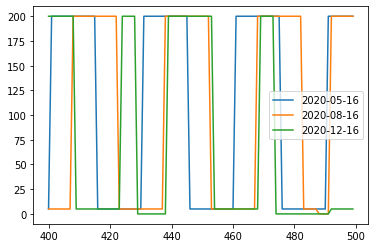

In [9]:
# plotting a part of the days
profiles.iloc[400:500].plot()

## Appliances with continuous duty cycle or productive use

By default, RAMP models duty cycle in contunuous mode. Given time of use window some switch-on events of random duration are generated and filled with duty cycles. If the duration of the switch-on events is longer than one duty cycle, the load profile is filled with repetitions of the duty cycle.

In case of productive uses such as welding, milling or the use of machinery in a carpentry, where appliances are switched on many times within the working hours, switch-on events duration should be limited to the duration of the duty cycle, resulting in one duty cycle per switch-on event.

In order to model an appliance having a productive use duty cycle, set the attribute `continuous_duty_cycle` to `0` as in this example below



You will simulate 1 day(s) from 2024-03-19 00:00:00 until 2024-03-20 00:00:00
      2020-12-16
0          0.001
1          0.001
2          0.001
3          0.001
4          5.000
...          ...
1435       0.001
1436       0.001
1437       0.001
1438       0.001
1439       0.001

[1440 rows x 1 columns]


<AxesSubplot:>

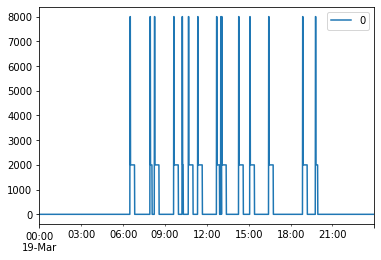

In [10]:
test_user = User(user_name="test_user", num_users=1)

# Create test appliance
test_appliance = test_user.add_appliance(
    name="test_appliance_with_duty_cycles",
    func_time=4 * 60,  # runs for 2 hours per day
    num_windows=1,
    window_1=[6 * 60, 20 * 60],  # usage timeframe from 06:00 to 20:00
    fixed_cycle=1,  # appliance uses duty cycles
    # Duty cycle 1
    p_11=8000,  # power of the first cycle
    t_11=2,  # time needed for the first cycle
    p_12=2000,  # power of the second cycle
    t_12=18,  # time needed for the second cycle
    continuous_duty_cycle=0,  # appliance run the duty cycle once per switch on event
)
# Create and initialize UseCase
uc = UseCase(name="duty_cycle_test", users=[test_user])
uc.initialize(num_days=1)

daily_load_profile = pd.DataFrame(
    uc.generate_daily_load_profiles(),
    index=uc.datetimeindex,
)

daily_load_profile.plot()

In order to illustrate how a continuous cycle woud look like, let's set the `continuous_duty_cycle` back to `1`

<AxesSubplot:>

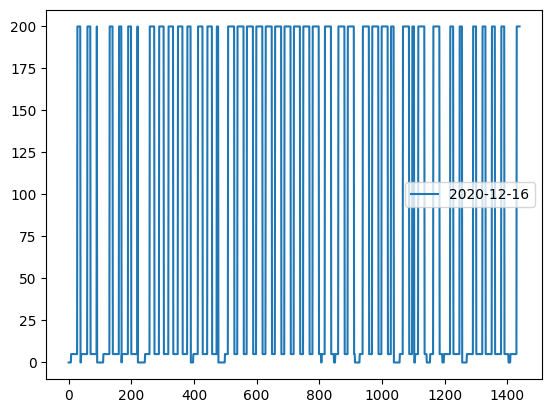

In [11]:
test_appliance.continuous_duty_cycle = 1

daily_load_profile = pd.DataFrame(
    uc.generate_daily_load_profiles(),
    index=uc.datetimeindex,
)

daily_load_profile.plot()# plotting the whole day
profiles.plot()

One can see that the switch on events are longer and more than one duty cycle run within the switch on event